# **Kickstarter project analysis : A performance prediction.(part 2)**

By Phongsathorn Chuisrikaeo

After finishing data cleaning and already found some basic insights from Exploring data analysis (EDA) process. Now, we will continue to the main work which is creating the prediction model for roughly predicting whether a kickstarter project will be successful before it is launched.



Before we get going I want to recall the main framework and explain briefly what we are gonna do next.

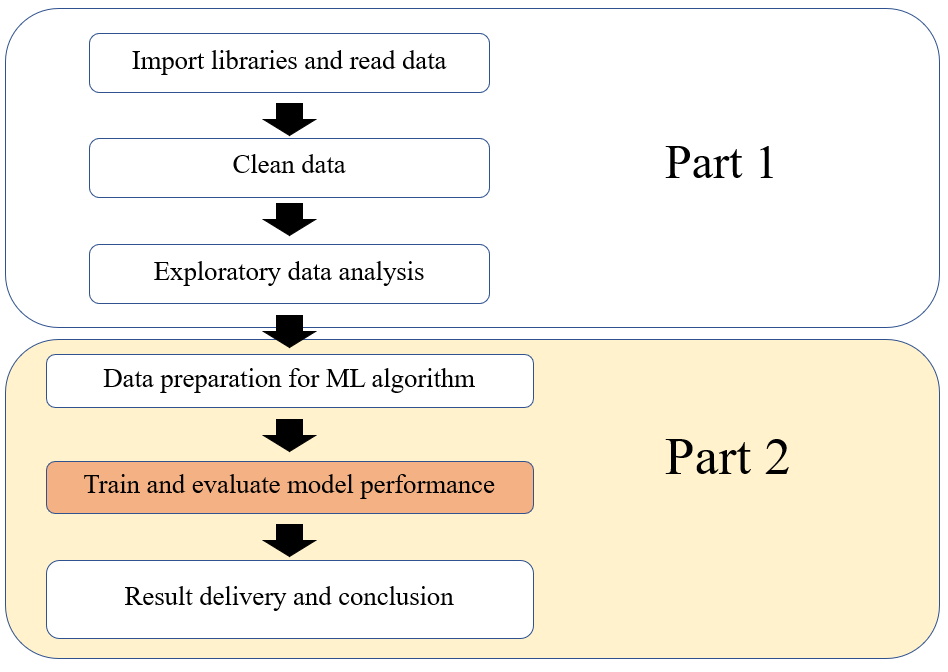


In part 2, we will start by recapping the information we got from EDA (we know from part 1 that which parameters should be included in the training ML models process)
Then, we choose only those features (and a label) and bring them into next process which is Data preparation for ML algorithm.
In that process, we will make the data to be ready to be used for training. Basically, what we would do are, change datatype, train-test-split, OneHotEncoding and FeatureScaling.
After that, we would have a dataset that would be ready for training a model.



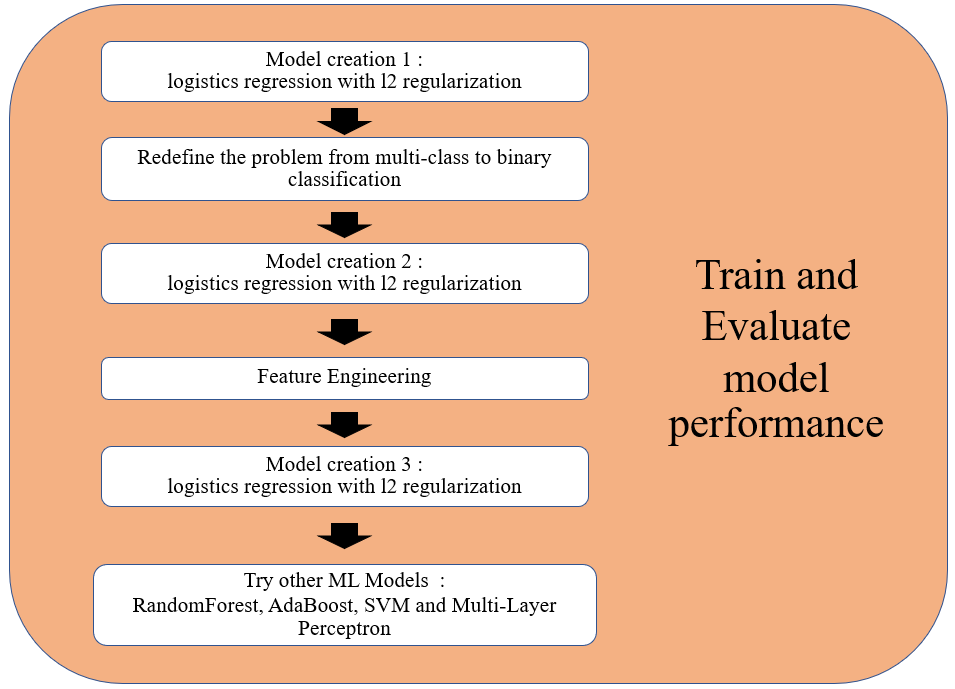



In Training and evaluating model process, we first train the model of logistic regression with l2 regularization with the dataset prepared in previous period. 
Then, we evaluated them beased on the confusion matrix and the classification report and we found the performance of the model is still not quite good.
Therefore, we redefined the problem from multi-class to binary classification by dropping the 'inconclusive' class from the label and then use the model of logistic regression with l2 regularization to fit with the dataset again (Model 2)and we found that the performance of the model is better but still have a problem with overfitting.
Therefore, we try to do some feature engineering by segment the 'usd_goal' and 'backers' columns and convert them from numerical columns into a categorical column.
After that, we use the model of logistic regression with l2 regularization to fit with the dataset again (Model 3) and this time the model have a good performance (>90% accuracy) on both training and test set.
For this reason, we did not improve the dataset further, instead, we try to use other ML models such as SVM, Random Forest, Adaboost and MLP to fit with the dataset using in Model 3 to see whether these ML models can give a better performance or not.

So that, we can pick the model that gives us the best performance to be deployed later.


**Let's get started !**

From Exploratory data analysis in the last notebook, now we know tentatively which parameters might affect the result of launching kickstarter project. The detail is shown below.

The parameters that probably affect the result of kickstarter project.
1. main category : because we know that there are some outstanding main categories which have the high successful rate (> 60%) compared with others. They are **Crafts, Fashion, Food,Journalism and Technology** 
2. usd_goal : because we know that when the pledged goal is higher, the successful rate would be lower as it is more difficult to reach the higher goal.
3. launched_year : because we found that %successful of the projects is highest in 2011 and fall significantly from 2014 to 2016. 
4. launched_time (hour) : because we know that it is a better time to launch a kickstarter project between 13.00 to 16.00.
5. backers : because we clearly see a trend which shows sthat more backers mean more amount of pledged money which could implies more probability of success.
6. duration : because duration more or less affects the successful rate of Kickstarter projects.
7. name_length : because we can see that the projects with name length less than 60 characters seem to get more pledged money than ones with more than 60 characters.
8. launched_month : because we found from EDA that between February and June, there are a little higher percentage of kickstarter project success.

this group of parameter would be included in Machine Learning model creation process as features.

The parameters that probably **DON'T ** affect the result of kickstarter project.
1. id : because it is just a unique id for each project.
2. name : actually we can extract them by using countvectorization but it is not yet covered in this study.
3. category : as we already have main category which includes all categories in it, there would be too thorough if we also include it, so in this study we just ignore it.
4. deadline : as we already include launch time and duration in the model so we do not have to put deadline in the model as it should be followed accordingly (launched_time + duration = deadline_time)
5. usd_pledged : as we would never known it until the project meets deadline.
6. country : it is the same as currency. E.g. project that launched in the US would have a value of 'USD' in the currency column already
7. currency : Although we found that the projects launch in USD have the highest successful rate followed by GBP and DKK, the column 'currency' in this dataset is highly imbalanced as USD is a huge dominant in this column while there are only a few samples with some currencies such as 'MXN' and this can cause further problem so we just simply drop it initially.

For target parameter or label we it should be the column of 'result', but further in this study, there would be adjusted a little (just for clarity).

**Remarks : we use 'df' dataset which includes outliers because outliers in this case is not an error and it has physical meaning. (actually, it is a project which is very successful (high number of backers, usd_pledged) or has a very high goal)

In [ ]:
# import libralies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#read data
df = pd.read_csv("/content/drive/MyDrive/dataset/kickstarter_cleaned_dataset.csv")
df.head(3)

,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd_pledged,usd_goal,result,duration,name_length,launched_year,launched_month,launched_weekday,launched_date,launched_time
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,...,0.0,1531.393568,failed,58,31,2015,August,Tuesday,2015-08-11 00:00:00,12
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,...,220.0,45000.000000,failed,45,14,2013,January,Saturday,2013-01-12 00:00:00,0
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,...,1.0,5000.000000,failed,30,49,2012,March,Saturday,2012-03-17 00:00:00,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302627 entries, 0 to 302626
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                302627 non-null  int64  
 1   name              302627 non-null  object 
 2   category          302627 non-null  object 
 3   main_category     302627 non-null  object 
 4   currency          302627 non-null  object 
 5   deadline          302627 non-null  object 
 6   goal              302627 non-null  float64
 7   launched          302627 non-null  object 
 8   pledged           302627 non-null  float64
 9   state             302627 non-null  object 
 10  backers           302627 non-null  float64
 11  country           302627 non-null  object 
 12  usd_pledged       302627 non-null  float64
 13  usd_goal          302627 non-null  float64
 14  result            302627 non-null  object 
 15  duration          302627 non-null  int64  
 16  name_length       30

# **1. Data Preparation**

In [ ]:
# change the data format first
df['name'] = df['name'].astype('string')

df[['category','main_category','currency','state','country']] = df[['category','main_category','currency','state','country']].astype('category')

df['deadline'] = pd.to_datetime(df['deadline'],format = '%Y-%m-%d %H:%M:%S')
df['launched'] = pd.to_datetime(df['launched'],format = '%Y-%m-%d %H:%M:%S')
df['launched_date'] = pd.to_datetime(df['launched_date'],format = '%Y-%m-%d')

df[['launched_weekday','launched_month']] = df[['launched_weekday','launched_month']].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302627 entries, 0 to 302626
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                302627 non-null  int64         
 1   name              302627 non-null  string        
 2   category          302627 non-null  category      
 3   main_category     302627 non-null  category      
 4   currency          302627 non-null  category      
 5   deadline          302627 non-null  datetime64[ns]
 6   goal              302627 non-null  float64       
 7   launched          302627 non-null  datetime64[ns]
 8   pledged           302627 non-null  float64       
 9   state             302627 non-null  category      
 10  backers           302627 non-null  float64       
 11  country           302627 non-null  category      
 12  usd_pledged       302627 non-null  float64       
 13  usd_goal          302627 non-null  float64       
 14  resu

In [ ]:
# import libralies for creating Machine learning model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OrdinalEncoder, 
    OneHotEncoder, 
    StandardScaler, 
    MinMaxScaler
)
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import plot_confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234) # fix the random combination

In [ ]:
df_mc = df.copy()
df_mc.head(3)

,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd_pledged,usd_goal,result,duration,name_length,launched_year,launched_month,launched_weekday,launched_date,launched_time
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,...,0.0,1531.393568,failed,58,31,2015,August,Tuesday,2015-08-11,12
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,...,220.0,45000.000000,failed,45,14,2013,January,Saturday,2013-01-12,0
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,...,1.0,5000.000000,failed,30,49,2012,March,Saturday,2012-03-17,3


In [ ]:
df_mc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302627 entries, 0 to 302626
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                302627 non-null  int64         
 1   name              302627 non-null  string        
 2   category          302627 non-null  category      
 3   main_category     302627 non-null  category      
 4   currency          302627 non-null  category      
 5   deadline          302627 non-null  datetime64[ns]
 6   goal              302627 non-null  float64       
 7   launched          302627 non-null  datetime64[ns]
 8   pledged           302627 non-null  float64       
 9   state             302627 non-null  category      
 10  backers           302627 non-null  float64       
 11  country           302627 non-null  category      
 12  usd_pledged       302627 non-null  float64       
 13  usd_goal          302627 non-null  float64       
 14  resu

In [ ]:
# Change format of launched year
df_mc['launched_year'] = df_mc['launched_year'].astype('int')

Set the feature and label as mentioned above.

In [ ]:
label = 'result'
feature = ['main_category','usd_goal','launched_year','launched_time','backers','duration','name_length','launched_month']
X = df_mc[feature]
y = df_mc[label]

Then, split the whole dataset into train (80%) and test set (20%). In my point of view, this dataset does not seem to be a time-series, so that we can shuffle it. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

After that, perform one-hot encoding for categorical columns and apply feature scaling to numerical columns. (On both train and test set)

In [ ]:
transformer = make_column_transformer(

( OneHotEncoder(), ['main_category','launched_month'] ),
(StandardScaler(),['duration','backers','name_length','launched_year','usd_goal','launched_time']),
remainder='passthrough'

)

In [ ]:
X_train_transformed = transformer.fit_transform(X_train)

In [ ]:
X_test_transformed = transformer.fit_transform(X_test)

Next, we create a logistic regression with l2 regularization (ridge) model based on the train set. We choose this model first because it is quite simple but effective to quickly see the performance. (and If it's not good enough we would just try to adjust something or change the model afterwards, but if its performance is acceptable, so we could just use it.) 

# **2. Model Creation (1)**

Logistic Regression with l2 regularization

In [ ]:
alphas = np.logspace(-3, 3, num=100) # Search for the best alphas
clf = LogisticRegressionCV(penalty='l2', Cs=alphas, cv=5)
clf.fit(X_train_transformed, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1.41747416e-02,
       1.62975083e-02, 1.87...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                     cv=5)

In [ ]:
clf.coef_ #check coefficient

array([[-4.21751709e-02, -3.53772249e-02,  2.17316537e-01,
        -2.10790863e-01,  1.55390298e-01,  1.70715453e-01,
        -2.28380500e-01,  1.67543437e-01,  1.30719731e-01,
         1.78093319e-01, -2.74403095e-01,  9.45665005e-02,
         1.22659630e-01,  1.67440161e-01, -2.80966157e-01,
         5.13620902e-02,  8.05516090e-02, -7.24222046e-02,
         2.82097563e-02,  9.82789829e-02,  1.02723311e-01,
         8.39213596e-02,  4.23806239e-02,  6.70474046e-02,
        -2.04300183e-01, -5.84770776e-03,  6.04470144e-02,
         2.58264469e-02, -1.41324681e+01, -1.99343804e-01,
        -1.16983568e-01,  6.27253423e+01,  5.04459959e-04],
       [-1.30186446e-01,  1.28842598e-01,  1.40427359e-02,
        -5.26409739e-01,  1.89987743e-01,  7.16018277e-02,
         2.58957739e-02, -1.62080308e-01,  7.87998633e-01,
         5.41943628e-02,  1.21562260e-01, -3.03044855e-02,
         1.50409763e-02,  1.01424187e-01, -3.71887683e-01,
        -1.01944936e-01,  1.37355998e-02,  2.49590510e-

In [ ]:
clf.intercept_ # check intercept (bias)

array([ 1.78710718,  0.53532399, -2.32243117])

## 2.1 Model(1) prediction

In [ ]:
y_pred_train = clf.predict(X_train_transformed)

In [ ]:
y_pred_test = clf.predict(X_test_transformed)

## 2.2 Model(1) Evaluation

### 2.2.1 Model(1) Evaluation on training set

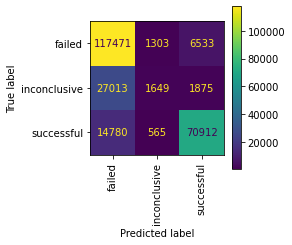

In [ ]:
# constucting a confusion matrix to basicly evaluate the performance of the model
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(clf, X_train_transformed, y_train, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# construct a classification report
report = classification_report(y_train, y_pred_train, output_dict=True)

In [ ]:
print('accuracy =', report['accuracy']) # check overall accuracy first

accuracy = 0.7849286041775952


Not so bad as we get > 78% accuracy but not good enough yet.

In [ ]:
pd.DataFrame.from_dict(report).T # then look at the full classification report

,precision,recall,f1-score,support
failed,0.737587,0.937466,0.825601,125307.000000
inconclusive,0.468866,0.054000,0.096846,30537.000000
successful,0.893999,0.822101,0.856544,86257.000000
accuracy,0.784929,0.784929,0.784929,0.784929
macro avg,0.700150,0.604522,0.592997,242101.000000
weighted avg,0.759419,0.784929,0.744705,242101.000000


Notice that our model performance is good on classifying the successful and failed class with more than 80% f1 score (harmonic mean between precision and recall) whereas the classifying performance on 'inconclusive' class is very bad (< 10% f1 score). 

**Remarks : precision is defined by TruePositive/ (True positive + False positive) and recall is defined by TruePositive/ (True positive + False Negative)

### 2.2.2 Model(1) Evaluation on test set

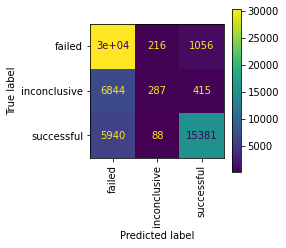

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(clf, X_test_transformed, y_test, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_test, y_pred_test, output_dict=True)

In [ ]:
print('accuracy =', report['accuracy'])

accuracy = 0.7594587450021478


In [ ]:
pd.DataFrame.from_dict(report).T

,precision,recall,f1-score,support
failed,0.703270,0.959710,0.811718,31571.000000
inconclusive,0.485618,0.038033,0.070542,7546.000000
successful,0.912711,0.718436,0.804004,21409.000000
accuracy,0.759459,0.759459,0.759459,0.759459
macro avg,0.700533,0.572060,0.562088,60526.000000
weighted avg,0.750217,0.759459,0.716584,60526.000000


On test set, it is not surprising as we got the similar result.The model performs well on classifying the successful and failed class with more than 80% f1 score whereas the classifying performance on 'inconclusive' class is very bad (< 10% f1 score).

It may be better if we drop 'inconclusive' class. Actually, this is a group of samples which we did not concentrate on at the first place. (In this study, classifying whether the kickstarter projects are successful or not is only what in our focus) Therefore, let's drop the 'inconclusive' class.

# 3. Removing 'inconclusive' class

For the purpose of clarity, now we will only consider whether a project was successful or unsuccesful so all projects that are not categorized as successful or unsuccessful will be removed.
For this reason, the projects with the 'inconclusive' result would be removed. (now, we try to convert a problem from multi-class classification into binary classification).

By doing this, there are about 87.4% of all undertakings, which are either successful or unsuccessful, left. 


In [ ]:
df_mc[df_mc['result'] == 'inconclusive'] 

,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd_pledged,usd_goal,result,duration,name_length,launched_year,launched_month,launched_weekday,launched_date,launched_time
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283.00,canceled,...,1283.000000,19500.000000,inconclusive,55,58,2015,July,Saturday,2015-07-04,8
7,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29 18:14:43,125000.0,2014-04-24 18:14:43,8233.00,canceled,...,8233.000000,125000.000000,inconclusive,35,53,2014,April,Thursday,2014-04-24,18
8,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10 21:55:48,65000.0,2014-07-11 21:55:48,6240.57,canceled,...,6240.570000,65000.000000,inconclusive,30,57,2014,July,Friday,2014-07-11,21
56,1000256760,"Raise the Woof, expanding the love (Canceled)",Design,Design,CAD,2015-08-07 21:46:53,15000.0,2015-07-08 21:46:53,700.00,canceled,...,533.455266,11431.184271,inconclusive,30,45,2015,July,Wednesday,2015-07-08,21
58,1000260691,Gizbee Unlimited Removable Storage for Your T...,Gadgets,Technology,USD,2016-03-25 19:30:27,87000.0,2016-02-29 20:30:27,2030.00,canceled,...,2030.000000,87000.000000,inconclusive,24,58,2016,February,Monday,2016-02-29,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302557,751491033,9thR Ohana Clothing emphhasizing art not just...,Ready-to-wear,Fashion,USD,2016-12-30 02:09:09,15000.0,2016-11-30 02:09:09,0.00,live,...,0.000000,15000.000000,inconclusive,30,56,2016,November,Wednesday,2016-11-30,2
302560,773654051,Vampiress Reign Of Darkness (Canceled),Shorts,Film & Video,USD,2014-11-10 19:58:31,2000.0,2014-09-26 19:58:31,0.00,canceled,...,0.000000,2000.000000,inconclusive,45,39,2014,September,Friday,2014-09-26,19
302575,822676159,Artisan Cuisine A Manual For Serious Food Ent...,Food,Food,USD,2012-06-01 20:53:57,25000.0,2012-05-02 20:53:57,250.00,canceled,...,250.000000,25000.000000,inconclusive,30,54,2012,May,Wednesday,2012-05-02,20
302613,952768436,THIS HAS BEEN MY DREAM FOR LIFE HELP ME ACCOM...,Hip-Hop,Music,USD,2015-11-15 04:12:22,750.0,2015-10-16 04:12:22,0.00,canceled,...,0.000000,750.000000,inconclusive,30,56,2015,October,Friday,2015-10-16,4


In [ ]:
df_mc2 = df_mc[df_mc['result'] != 'inconclusive'] # drop all projects with 'inconclusive' result
df_mc2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264544 entries, 0 to 302626
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                264544 non-null  int64         
 1   name              264544 non-null  string        
 2   category          264544 non-null  category      
 3   main_category     264544 non-null  category      
 4   currency          264544 non-null  category      
 5   deadline          264544 non-null  datetime64[ns]
 6   goal              264544 non-null  float64       
 7   launched          264544 non-null  datetime64[ns]
 8   pledged           264544 non-null  float64       
 9   state             264544 non-null  category      
 10  backers           264544 non-null  float64       
 11  country           264544 non-null  category      
 12  usd_pledged       264544 non-null  float64       
 13  usd_goal          264544 non-null  float64       
 14  resu

# 4. Redo a data preparation

As we removed the 'inconclusive' class, so that we have to redo the data preparation again.

In [ ]:
label = 'result'
feature = ['main_category','usd_goal','launched_year','launched_time','backers','duration','name_length','launched_month']
X = df_mc2[feature] # use df_mc2 instead
y = df_mc2[label] # use df_mc2 instead

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True) # train test split

#transform columns
transformer2 = make_column_transformer(

( OneHotEncoder(handle_unknown = 'ignore'), ['main_category','launched_month'] ),
(StandardScaler(),['duration','backers','name_length','launched_year','usd_goal','launched_time']),
remainder='passthrough'

)

X_train_transformed2 = transformer2.fit_transform(X_train)
X_test_transformed2 = transformer2.fit_transform(X_test)

# **5. Model Creation (2)**

Logistic Regression with l2 regularization (again)

In [ ]:
alphas = np.logspace(-3, 3, num=100)
clf2 = LogisticRegressionCV(penalty='l2', Cs=alphas, cv=5)
clf2.fit(X_train_transformed2, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1.41747416e-02,
       1.62975083e-02, 1.87...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                     cv=5)

In [ ]:
clf2.coef_

array([[ 2.79728963e-01, -2.45673513e-01, -3.81349229e-01,
         9.57494594e-01, -5.12146644e-01, -3.65481273e-01,
         5.21224476e-01, -1.48253910e-01, -1.34620881e+00,
        -3.05659690e-01,  4.17562307e-01, -1.03505115e-01,
        -2.46511567e-01, -3.25883232e-01,  9.72070660e-01,
         1.27672942e-02, -1.52381197e-01, -6.58370980e-02,
         4.14773404e-02, -1.18519016e-01, -1.95401078e-01,
        -9.66053983e-02,  2.93824939e-02, -7.58168128e-02,
        -7.11272765e-02, -5.94010785e-02, -8.11301559e-02,
        -1.75724464e-01,  5.02100937e+01,  8.69755220e-02,
        -8.18111705e-02, -2.42765398e+02,  1.94013833e-03]])

In [ ]:
clf2.intercept_

array([-3.84033839])

## Model(2) prediction

In [ ]:
y_pred_train2 = clf2.predict(X_train_transformed2)


In [ ]:
y_pred_test2 = clf2.predict(X_test_transformed2)

## Model(2) Evaluation

### Model(2) Evaluation on training set

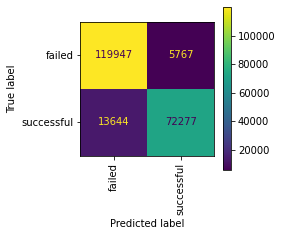

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(clf2, X_train_transformed2, y_train, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_train, y_pred_train2, output_dict=True)
print('accuracy =', report['accuracy'])
pd.DataFrame.from_dict(report).T

accuracy = 0.9082807664138729


,precision,recall,f1-score,support
failed,0.897867,0.954126,0.925142,125714.000000
successful,0.926106,0.841203,0.881615,85921.000000
accuracy,0.908281,0.908281,0.908281,0.908281
macro avg,0.911987,0.897664,0.903379,211635.000000
weighted avg,0.909332,0.908281,0.907471,211635.000000


The model performance on training set is boosted up suddenly after dropping an 'inconclusive' class.

### Model(2) Evaluation on test set

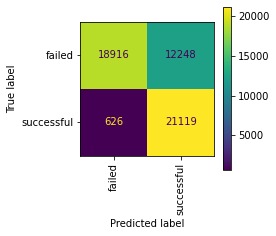

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(clf2, X_test_transformed2, y_test, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_test, y_pred_test2, output_dict=True)
print('accuracy =', report['accuracy'])
pd.DataFrame.from_dict(report).T

accuracy = 0.7566765578635015


,precision,recall,f1-score,support
failed,0.967966,0.606982,0.746105,31164.000000
successful,0.632931,0.971212,0.766403,21745.000000
accuracy,0.756677,0.756677,0.756677,0.756677
macro avg,0.800449,0.789097,0.756254,52909.000000
weighted avg,0.830271,0.756677,0.754447,52909.000000


However, the model performance on the test set is still not that good and stays at the same level as before dropping an 'inconclusive' class. This implies that there might be an overfitting problem. For this reason, we would try to do some more feature engineering and then, try to apply other ML algorithms afterwards.

# Further Feature Engineering

As for 'usd_goal' and 'backers' are numerical columns and we knew that both columns contain a lot of outliers since the Exploratory Data analysis process. Therefore, now we try to convert the type of these columns and from a numerical type to a categorical type by putting the value in bins and see whether or not it can help increasing the performance of the model.

In [ ]:
pd.qcut(df_mc2['usd_goal'],q=5,precision=1) # we put usd_goal in to 5 bins which contain the same number of samples

0                       (1500.0, 4000.0]
1                 (20000.0, 166107382.6]
2                       (4000.0, 8000.0]
4                 (20000.0, 166107382.6]
5         (-0.09000000000000001, 1500.0]
                       ...              
302622            (20000.0, 166107382.6]
302623                  (1500.0, 4000.0]
302624    (-0.09000000000000001, 1500.0]
302625            (20000.0, 166107382.6]
302626                  (1500.0, 4000.0]
Name: usd_goal, Length: 264544, dtype: category
Categories (5, interval[float64, right]): [(-0.09000000000000001, 1500.0] < (1500.0, 4000.0] < (4000.0, 8000.0] <
                                           (8000.0, 20000.0] < (20000.0, 166107382.6]]

In [ ]:
conditions = [df_mc2['usd_goal'] >20000 ,
              (df_mc2['usd_goal'] <=20000 ) & (df_mc2['usd_goal'] >8000 ),
              (df_mc2['usd_goal'] <=8000 ) & (df_mc2['usd_goal'] >4000 ),
              (df_mc2['usd_goal'] <=4000 ) & (df_mc2['usd_goal'] >1500 ),
              (df_mc2['usd_goal'] <=1500 ) ]
              
choices =['>20000','8000 - 20000','4000-8000','1500-4000','<1500']

df_mc2['usd_goal_cat'] = np.select(conditions,choices) # create new column as a usd_goal category

In [ ]:
pd.qcut(df_mc2['backers'],q=5,precision=1)# we put backers in to 5 bins which contain the same number of samples

0              (-0.1, 1.0]
1               (1.0, 7.0]
2              (-0.1, 1.0]
4         (83.0, 219382.0]
5              (7.0, 28.0]
                ...       
302622          (1.0, 7.0]
302623         (-0.1, 1.0]
302624          (1.0, 7.0]
302625         (7.0, 28.0]
302626        (28.0, 83.0]
Name: backers, Length: 264544, dtype: category
Categories (5, interval[float64, right]): [(-0.1, 1.0] < (1.0, 7.0] < (7.0, 28.0] < (28.0, 83.0] <
                                           (83.0, 219382.0]]

In [ ]:
conditions = [df_mc2['backers'] > 83,
              (df_mc2['backers'] <= 83) & (df_mc2['backers'] > 28),
              (df_mc2['backers'] <= 28) & (df_mc2['backers'] > 7),
              (df_mc2['backers'] <= 7) & (df_mc2['backers'] > 1),
              df_mc2['backers'] < 1,
              ]
choices =['>83','28-83','7-28','1-7','<1'
          ]
df_mc2['backers_cat'] = np.select(conditions,choices)
df_mc2.head() # create new column as a backers category

,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,result,duration,name_length,launched_year,launched_month,launched_weekday,launched_date,launched_time,usd_goal_cat,backers_cat
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,...,failed,58,31,2015,August,Tuesday,2015-08-11,12,1500-4000,<1
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,...,failed,45,14,2013,January,Saturday,2013-01-12,0,>20000,1-7
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,...,failed,30,49,2012,March,Saturday,2012-03-17,3,4000-8000,0
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000.0,2016-02-26 13:38:27,52375.0,successful,...,successful,35,20,2016,February,Friday,2016-02-26,13,>20000,>83
5,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21 18:30:44,1000.0,2014-12-01 18:30:44,1205.0,successful,...,successful,20,60,2014,December,Monday,2014-12-01,18,<1500,7-28


# Redo a data preparation

As we decided to use 'usd_goal_cat' and 'backers_cat' columns instead, so that we have to redo the data preparation again accordingly.

In [ ]:
label = 'result'
feature = ['main_category','usd_goal_cat','launched_year','launched_time','backers_cat','duration','name_length','launched_month'] # use usd_goal_cat and backers_cat instead
X = df_mc2[feature] 
y = df_mc2[label] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True) # train test split

#transform columns
transformer = make_column_transformer(

( OneHotEncoder(), ['main_category','backers_cat','usd_goal_cat','launched_month'] ),
(StandardScaler(),['duration','name_length','launched_year','launched_time']),
remainder='passthrough'

)

X_train_transformed3 = transformer.fit_transform(X_train)
X_test_transformed3 = transformer.fit_transform(X_test)

#**Model Creation (3)**

In [ ]:
alphas = np.logspace(-3, 3, num=100)
clf3 = LogisticRegressionCV(penalty='l2', Cs=alphas, cv=5)
clf3.fit(X_train_transformed3, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1.41747416e-02,
       1.62975083e-02, 1.87...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                     cv=5)

In [ ]:
clf3.coef_

array([[ 3.34496006e-01, -5.50311808e-01, -3.58455142e-01,
         8.45021233e-01, -5.85035046e-01, -1.58224030e-01,
         5.51298181e-01, -5.78534249e-02, -9.08822421e-01,
        -6.36815200e-03,  5.22027170e-01,  3.36694631e-02,
        -2.27428118e-01, -3.20466070e-01,  8.86117413e-01,
        -3.48364845e+00, -2.45702481e+00,  3.35306965e+00,
         4.76034414e-01, -4.18416049e+00,  6.29539493e+00,
         1.23896428e+00, -9.32750758e-02, -1.47777550e+00,
         3.15858486e+00, -2.82683331e+00,  5.20124953e-02,
        -4.73436625e-02,  1.69635104e-02,  7.44263058e-02,
        -3.67040182e-02, -4.02784191e-02, -5.20705454e-02,
         8.15845234e-02, -1.84432759e-02,  1.80058000e-03,
        -2.46629363e-02, -7.61930409e-03, -1.43672490e-01,
         3.29633763e-02,  2.44836722e-02,  1.49018259e-02]])

In [ ]:
clf3.intercept_

array([-2.4339797])

## Model(3) prediction

In [ ]:
y_pred_train3 = clf3.predict(X_train_transformed3)
y_pred_test3 = clf3.predict(X_test_transformed3)

## Model(3) Evaluation

## Model(3) Evaluation on training set

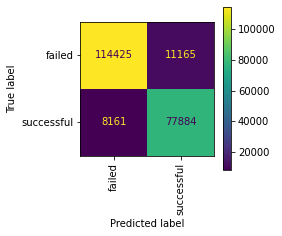

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(clf3, X_train_transformed3, y_train, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_train, y_pred_train3, output_dict=True)
print('accuracy =', report['accuracy'])
pd.DataFrame.from_dict(report).T

accuracy = 0.9086824013041321


,precision,recall,f1-score,support
failed,0.933426,0.911100,0.922128,125590.000000
successful,0.874620,0.905154,0.889625,86045.000000
accuracy,0.908682,0.908682,0.908682,0.908682
macro avg,0.904023,0.908127,0.905876,211635.000000
weighted avg,0.909517,0.908682,0.908913,211635.000000


The model performance on training set stays at the same level as before feature engineering.

## Model(3) Evaluation on test set

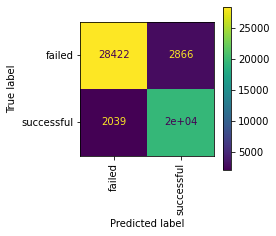

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(clf3, X_test_transformed3, y_test, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_test, y_pred_test3, output_dict=True)
print('accuracy =', report['accuracy'])
pd.DataFrame.from_dict(report).T

accuracy = 0.9072936551437374


,precision,recall,f1-score,support
failed,0.933062,0.908399,0.920566,31288.000000
successful,0.872327,0.905694,0.888697,21621.000000
accuracy,0.907294,0.907294,0.907294,0.907294
macro avg,0.902695,0.907046,0.904631,52909.000000
weighted avg,0.908243,0.907294,0.907543,52909.000000


Anyway, after performing feature engineering, the model performance is now boosted up to the same level as performance on training set (> 90% accuracy) and this is basically good enough.
However, this algorithm is just a performance of model of logistics regression with l2 regularization which basically the simple algorithm. Therefore, now we try to apply more complex ML model to see whether or not the prediction performance would increased.  

we would apply random forest, Adaboost, Support Vector Machine and Multi-layer perceptron respectively.

# Let's try with other algorithm

## Random Forest

### Model Creation (Random forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV

In [ ]:
# we want to find the best hyperparameters for random forest model so that we determine the gridsearch set of parameters
parameter_grid = {'n_estimators':[1000,1500,2000],
                  'max_depth':[3,5,7,9,11]}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           parameter_grid,
                           cv=2)  
# Actually cv should be 1 (because no need to do cv in random forest) but GridsearchCV doesn't allow cv = 1 so we use 2 instead

In [ ]:
grid_search.fit(X_train_transformed3, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'n_estimators': [1000, 1500, 2000]})

In [ ]:
grid_search.best_params_ #For this dataset, the most suitable kind of tree is that we want tree with high depth but not so many trees (in this case 1500 trees)

{'max_depth': 11, 'n_estimators': 1500}

In [ ]:
grid_search.best_score_

0.9079878110508653

Actually we have tried to search on a variety of values on max_depth and n_estimators already, and each time we get different kind of trees which is more suitable for the dataset (E.g. if I set max-depth to [5,7,9,11,13,15] we may get that the best_params_ would be max-depth = 15 and n_estimators = 1500 for example) Anyway, we found that the performance of the model would not change much (still roughly around 89 - 91%) so that we just pick one set of parameters to use. In this case, we just use max_depth= 11 and n_estimators = 1500.

### Model Prediction (random forest)

In [ ]:
y_pred_train_rnd_clf = grid_search.predict(X_train_transformed3)
y_pred_test_rnd_clf  = grid_search.predict(X_test_transformed3)

### Model Evaluation on training set (random forest)

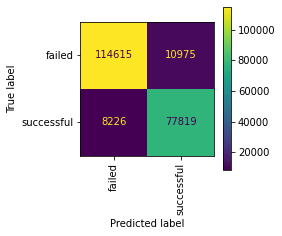

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(grid_search, X_train_transformed3, y_train, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_train, y_pred_train_rnd_clf , output_dict=True)
print('accuracy =', report['accuracy'])
pd.DataFrame.from_dict(report).T

accuracy = 0.9092730408486309


,precision,recall,f1-score,support
failed,0.933035,0.912612,0.922711,125590.000000
successful,0.876399,0.904399,0.890179,86045.000000
accuracy,0.909273,0.909273,0.909273,0.909273
macro avg,0.904717,0.908506,0.906445,211635.000000
weighted avg,0.910009,0.909273,0.909484,211635.000000


The performance on training set of random forest model is very similar to the previous logistic regression model just a little bit better. (No significant different)

### Model Evaluation on Test set (random forest)

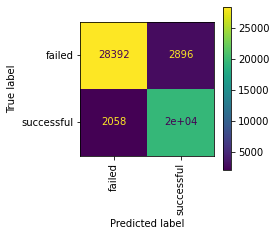

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(grid_search, X_test_transformed3, y_test, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_test, y_pred_test_rnd_clf , output_dict=True)
print('accuracy =', report['accuracy'])
pd.DataFrame.from_dict(report).T

accuracy = 0.9063675367139806


,precision,recall,f1-score,support
failed,0.932414,0.907441,0.919758,31288.000000
successful,0.871054,0.904815,0.887613,21621.000000
accuracy,0.906368,0.906368,0.906368,0.906368
macro avg,0.901734,0.906128,0.903686,52909.000000
weighted avg,0.907339,0.906368,0.906622,52909.000000


The result on test set is similar to training set that the performance of random forest model is almost the same as the previous logistic regression with No significant different.

In [ ]:
# Special thing from random forest algorithm is that we can find feature importance as shown below.
grid_search.best_estimator_.feature_importances_ 

array([6.53115397e-04, 9.23546921e-04, 3.48730963e-04, 9.77538450e-04,
       2.34476268e-03, 1.08110023e-03, 1.54912704e-03, 1.27632492e-03,
       3.42898515e-03, 9.56537660e-05, 6.28359870e-03, 1.04733683e-04,
       8.04676400e-04, 3.29101940e-03, 3.50707710e-03, 7.04176066e-02,
       1.38218474e-01, 1.35663819e-01, 5.57406623e-02, 9.88965591e-02,
       2.87001240e-01, 1.93302140e-02, 9.37072908e-03, 2.43556937e-02,
       5.27732066e-02, 4.86163569e-02, 2.26642049e-04, 1.75267261e-04,
       1.55935829e-04, 1.75527667e-04, 1.61142990e-04, 2.86881546e-04,
       1.66756240e-04, 2.07171775e-04, 1.72463494e-04, 1.76935502e-04,
       1.71957805e-04, 1.76201412e-04, 1.40802925e-02, 6.08183795e-03,
       8.36381566e-03, 2.16661739e-03])

** We look at the feature importance to know which features are important and which are not so that we can drop it in the further study.


In [ ]:
transformer.get_feature_names_out()

array(['onehotencoder__main_category_Art',
       'onehotencoder__main_category_Comics',
       'onehotencoder__main_category_Crafts',
       'onehotencoder__main_category_Dance',
       'onehotencoder__main_category_Design',
       'onehotencoder__main_category_Fashion',
       'onehotencoder__main_category_Film & Video',
       'onehotencoder__main_category_Food',
       'onehotencoder__main_category_Games',
       'onehotencoder__main_category_Journalism',
       'onehotencoder__main_category_Music',
       'onehotencoder__main_category_Photography',
       'onehotencoder__main_category_Publishing',
       'onehotencoder__main_category_Technology',
       'onehotencoder__main_category_Theater',
       'onehotencoder__backers_cat_0', 'onehotencoder__backers_cat_1-7',
       'onehotencoder__backers_cat_28-83',
       'onehotencoder__backers_cat_7-28', 'onehotencoder__backers_cat_<1',
       'onehotencoder__backers_cat_>83',
       'onehotencoder__usd_goal_cat_1500-4000',
       'oneho

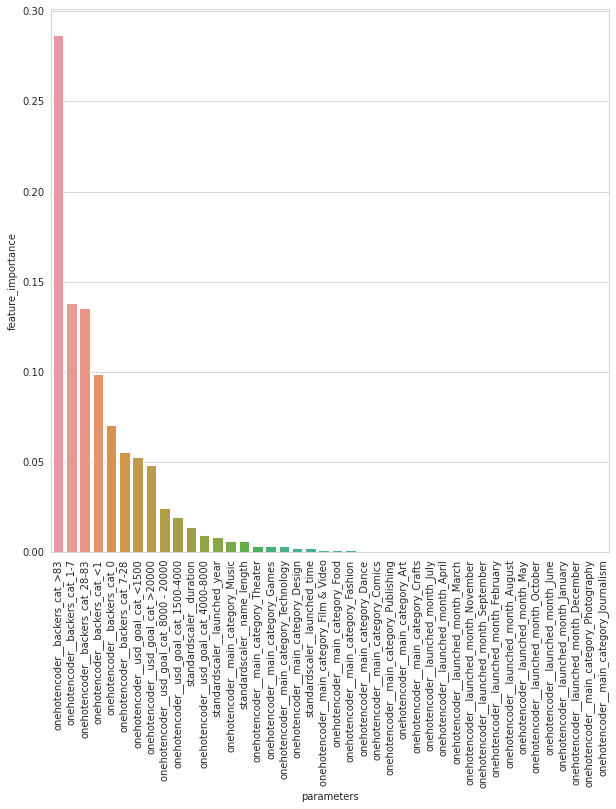

In [ ]:
# Visualize the feature importance for each feature

table_feaimp =  list(zip(transformer.get_feature_names_out(),grid_search.best_estimator_.feature_importances_))
table_feaimp = pd.DataFrame(table_feaimp, columns = ['parameters','feature_importance'])
table_feaimp = table_feaimp.sort_values(by = 'feature_importance', ascending = False).reset_index()

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (10,10))
sns.barplot(data = table_feaimp, x = 'parameters', y= 'feature_importance')
plt.xticks(rotation = 90)
plt.show()

According to random forest.features_importances_, we can see that the most importance features are actually related to backers column, the second most importance are related to usd_goal which implies that backers and usd_goal category which we create in the previous process (further feature engineering) are quite useful for the model to classify successful and failed projects.

## ADA boosting

### Model Creation (ADA)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Try to find the best parameteres to use for adaboost
parameter_grid_ada = {'n_estimators':[10,30,50,70,90],
                  'learning_rate':[0.2,0.3,0.4,0.5,0.6,0.7]}

In [ ]:
grid_search_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3)),
                           parameter_grid_ada,
                           cv=3)

In [ ]:
grid_search_ada.fit(X_train_transformed3, y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3)),
             param_grid={'learning_rate': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                         'n_estimators': [10, 30, 50, 70, 90]})

In [ ]:
grid_search_ada.best_params_

{'learning_rate': 0.2, 'n_estimators': 90}

In [ ]:
grid_search_ada.best_score_

0.9101330120254211

### Model Prediction (ADA)

In [ ]:
y_pred_train_ada = grid_search_ada.predict(X_train_transformed3)
y_pred_test_ada = grid_search_ada.predict(X_test_transformed3)

### Model Evaluation on Training set (ADA)

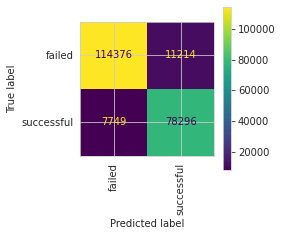

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(grid_search_ada, X_train_transformed3, y_train, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_train, y_pred_train_ada, output_dict=True)
print('accuracy =', report['accuracy'])
pd.DataFrame.from_dict(report).T

accuracy = 0.9103976185413566


,precision,recall,f1-score,support
failed,0.936549,0.910709,0.923448,125590.000000
successful,0.874718,0.909942,0.891983,86045.000000
accuracy,0.910398,0.910398,0.910398,0.910398
macro avg,0.905633,0.910326,0.907715,211635.000000
weighted avg,0.911410,0.910398,0.910655,211635.000000


Apparently, Adaboost model gives us the best classification performance so far on training set with 91% accuracy.

### Model Evaluation on Test set (ADA)

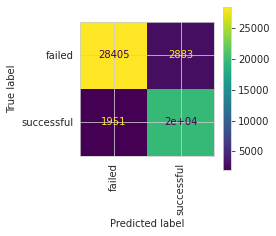

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(grid_search_ada, X_test_transformed3, y_test, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_test, y_pred_test_ada, output_dict=True)
print('accuracy =', report['accuracy'])
pd.DataFrame.from_dict(report).T

accuracy = 0.9086355818480788


,precision,recall,f1-score,support
failed,0.935729,0.907856,0.921582,31288.000000
successful,0.872168,0.909764,0.890569,21621.000000
accuracy,0.908636,0.908636,0.908636,0.908636
macro avg,0.903949,0.908810,0.906076,52909.000000
weighted avg,0.909755,0.908636,0.908909,52909.000000


For the test set, Adaboost model also give us the best performance so far with almost 91% accuracy. Let's see if SVM and MLP can give us better performance.

## Support Vector Machine (SVM)

### Model Creation (SVM)

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc= SVC()
svc.fit(X_train_transformed3, y_train)

SVC()

We decided to use SVC with default parameters { kernel = 'rbf', C (penalty) =1.0, gamma = 'scale' (gamma = 1 / (n_features * X.var())) , max_iter = -1 (no limit) } and did not search for the best set of parameters because it is massively time consuming. 

### Model Prediction (SVM)

In [ ]:
y_pred_train_svc = svc.predict(X_train_transformed3)
y_pred_test_svc = svc.predict(X_test_transformed3)

### Model Evaluation on Training set (SVM)

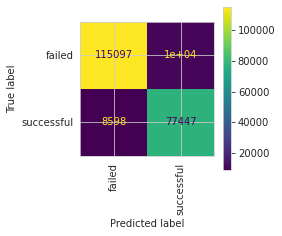

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(svc, X_train_transformed3, y_train, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_train, y_pred_train_svc, output_dict=True)
print('accuracy =', report['accuracy'])
pd.DataFrame.from_dict(report).T

accuracy = 0.9097928036477898


,precision,recall,f1-score,support
failed,0.930490,0.916450,0.923417,125590.000000
successful,0.880680,0.900076,0.890272,86045.000000
accuracy,0.909793,0.909793,0.909793,0.909793
macro avg,0.905585,0.908263,0.906845,211635.000000
weighted avg,0.910239,0.909793,0.909941,211635.000000


We found that even with the default setting of SVC, it gives a satisfied result on training set with almost 91% accuracy already.

###Model Evaluation on Test set (SVM)

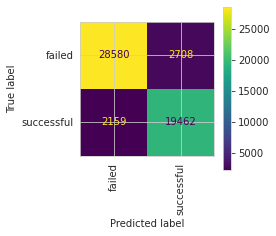

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(svc, X_test_transformed3, y_test, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_test, y_pred_test_svc, output_dict=True)
print('accuracy =', report['accuracy'])
pd.DataFrame.from_dict(report).T

accuracy = 0.9080118694362018


,precision,recall,f1-score,support
failed,0.929763,0.913449,0.921534,31288.000000
successful,0.877853,0.900143,0.888858,21621.000000
accuracy,0.908012,0.908012,0.908012,0.908012
macro avg,0.903808,0.906796,0.905196,52909.000000
weighted avg,0.908551,0.908012,0.908181,52909.000000


The performance on test set is also quite good and have no significant differences compared with other models so far.

The next and last model we would try to apply is a Multi-layer perceptron model which is in the field of deep learning.

## Multi-Layer Perceptron (MLP)

###Model Creation (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp_clf = MLPClassifier(
    hidden_layer_sizes = (20,5),
    learning_rate_init=0.05,
    max_iter=50000,
    batch_size=64,
    alpha = 1,
    activation = 'relu',
    solver = 'adam',
    beta_1=0.9,
    beta_2=0.999
)

** Remarks: We have tried to change hidden_layer_sizes (and also other parameters) for a while but the result we got was not significantly changed, so that we just stick with the simplest one ( = (20,5)) which gave an acceptable result (around 89-91% accuracy).

In [ ]:
mlp_clf.fit(X_train_transformed3,y_train)

MLPClassifier(alpha=1, batch_size=64, hidden_layer_sizes=(20, 5),
              learning_rate_init=0.05, max_iter=50000)

In [ ]:
for coef in mlp_clf.coefs_:
    print(coef.shape)

(42, 20)
(20, 5)
(5, 1)


In [ ]:
for intercept in mlp_clf.intercepts_:
    print(intercept.shape)

(20,)
(5,)
(1,)


### Loss curve

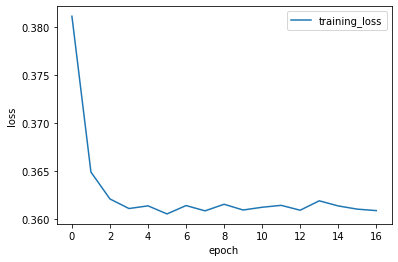

In [ ]:
# check loss curve
plt.plot(mlp_clf.loss_curve_, label='training_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

Loss curve looks acceptable as it decreased and then stable.

### Model Prediction (MLP)

In [ ]:
y_pred_train_mlp = mlp_clf.predict(X_train_transformed3)
y_pred_test_mlp = mlp_clf.predict(X_test_transformed3)

### Model Evaluation on Training set (MLP)

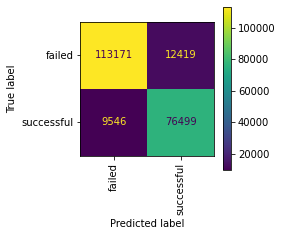

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(mlp_clf, X_train_transformed3, y_train, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_train, y_pred_train_mlp, output_dict=True)
print('accuracy =', report['accuracy'])
pd.DataFrame.from_dict(report).T

accuracy = 0.8962128192406738


,precision,recall,f1-score,support
failed,0.922211,0.901115,0.911541,125590.000000
successful,0.860332,0.889058,0.874459,86045.000000
accuracy,0.896213,0.896213,0.896213,0.896213
macro avg,0.891272,0.895086,0.893000,211635.000000
weighted avg,0.897053,0.896213,0.896465,211635.000000


The MLP model performance on training set is not significantly different from other models applied so far. Actually, it's a little worse but by tuning a little more thoroughly you would get a little better performance.
As long as, I tuned it so far, the accuracy of this model is best around 89 - 91 %.

###Model Evaluation on Test set (MLP)

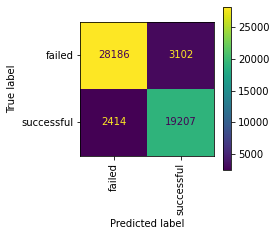

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_confusion_matrix(mlp_clf, X_test_transformed3, y_test, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
report = classification_report(y_test, y_pred_test_mlp, output_dict=True)
print('accuracy =', report['accuracy'])
pd.DataFrame.from_dict(report).T

accuracy = 0.8957455253359542


,precision,recall,f1-score,support
failed,0.921111,0.900857,0.910871,31288.000000
successful,0.860953,0.888349,0.874437,21621.000000
accuracy,0.895746,0.895746,0.895746,0.895746
macro avg,0.891032,0.894603,0.892654,52909.000000
weighted avg,0.896528,0.895746,0.895982,52909.000000


The MLP model performance on test set was not different from the performance on training set.

# **Discussion and Suggestion**

From all classification results above, we can conclude the performance of each model as shown in the table below.

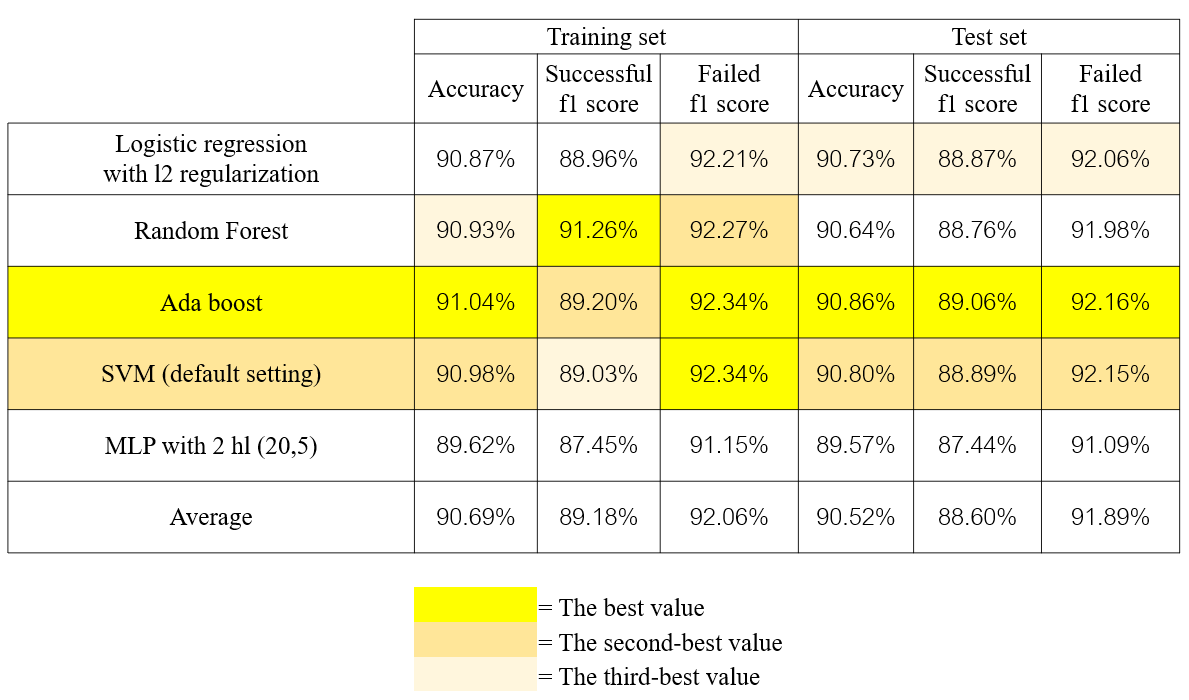

**Remarks : We construct the table with accuracy and f1-score because f1-score is a weighted harmonic mean between recall and precision which can reflect both recall and precision (E.g. if f1-score is high, it means recall and precision is high)

According to the table we clearly see that Adaboost model has the best performance with 91.04% accuracy on training set and 90.86% accuracy on test set which means that the model guesses 91 out of 100 times right (whether the projects are successful of failed) in training set and 90 out of 100 times right on test set (unseen data). The adaboost model also have high precision on both training and test set (E.g. 93.65% on training set, 93.57% on test set for 'failed' class which means that more than 93 out of 100 times that the model predicts the project is 'failed', it is right.)

and also high recall on both training and test set (E.g. 91.07% on training set, 90.79% on test set for 'failed' class which means that if there are 'failed' 100 samples, more than 90 samples would be detected or found by the model.) These are quite satisfied result.

The second best model for this dataset seems to be the random forest model. Actually, the random forest model performance is not far behind Adaboost we can see it from the table above.

Apart from good performance, the random forest model can also shows the feature importances that implies the backers_cat and usd_goal_cat column that we created in the feature engineering process are quite useful for the model to classify successful and failed projects, as evidenced by the fact that the features with the highest importance are related to the backers_cat column and usd_goal_cat, respectively. 

Looking in more details in each model performance we can see that almost all models give a little better precision, recall and f1 score in 'failed' case than in 'successful' case. In other words, the models are a little more good at detecting 'failed' projects than 'successful' projects.

Finally, about limitation and suggestion for further study in the future, we know that this study is based on secondary data retrieved from kaggle.com. 
As a result, the accuracy of this
study is also dependent on the accuracy of the secondary source of information. Furthermore,
the approach and models used in the prediction section is a rudimentary model that can be used for
a tentative forecast. Therefore, more official information should be explored further and probably used other method to do an exchange rate conversion (E.g. using Fixer.io API) in order
to provide a more particular, correct, and full outcome. Similarly, more advanced prediction
algorithms such as XGboost should be applied in the further study.

Countvectorization can also be applied to extract words(features 'name') in project's name which may affect the probability of success of Kickstarter projects. One more weakness of the model in this study is that the input data is from 2009 - 2016 and as we included launched_year in the model, so that the model may not work well with the projects that launched after 2016 as it would be out of input data range. 

Although there are many areas to be improved, I believe the final adaboost model created in this study is still good enough to be used for **'ROUGHLY'** predicting the outcome of the Kickstarter project based on its profile and more or less benefits Kickstarter's project owners, supporters as well as those who apply the same approach to their projects (E.g. in an investment feasibility study).

# **Conclusion**

In conclusion, overall, we found that all models have approximately the same performance with roughly 90% accuracy while the models tend to be a little more precise in predicting 'failed' class than 'successful' class according to precision, recall and f1 score.

The Adaboost is the best model in this study which gives the best result. Therefore, if you want the best performance model, this Adaboost model would be a good option to be used for predciting the outcome of your Kickstarter project.